# KPI Metrics Visualization

Through this notebook, we want to provide a way for users to explore and visualize the available KPI metrics. Although we plan on setting up external tools (such as Apache Superset) for visualization, we also want to provide the option to visualize KPIs in a Jupyter notebook native environment since that is where a lot of data science development happens.

This notebook comprises of the three main sections:
1. Fetch and view available data from Ceph bucket
2. Create graphs at the job level
3. Create graphs at the test level

In [1]:
# Import required libraries
import os
from tqdm import tqdm
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from ipynb.fs.defs.metric_template import CephCommunication

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## Get KPI Data

In [4]:
# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_metric_objs = metrics_bucket.objects.filter(Prefix=s3_path)

In [5]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_metric_objs = defaultdict(list)
dates_available_for_metric_objs = defaultdict(list)

for obj in tqdm(available_metric_objs):

    # NOTE: this file is an inconsistency that resulted from previous experimentation phases
    # it should ideally be removed from the bucket at some point
    if obj.key == "metrics/flake.parquet":
        continue

    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")

    # update dictionary if key doesnt exist
    if metric_obj_name not in kpis_in_metric_objs:
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_metric_objs[metric_obj_name] = kpis

    # update mapping of "metric name": "dates for which data is available"
    date = file_name.split("-", maxsplit=1)[-1].split(".", maxsplit=1)[0]
    dates_available_for_metric_objs[metric_obj_name].append(date)

61it [00:19,  3.06it/s]


**NOTE** The following kpi file / metric / date selection process is a bit restricted right now since ipywidgets are currently unavailable, but should be more interactive once that issue is resolved.

In [6]:
print("Available KPI files to choose from:", end="\n\n")
for k in kpis_in_metric_objs.keys():
    print(k)

Available KPI files to choose from:

avg_correlation
blocked_timed_out
build_pass_failure
correlation
number_of_flakes
pct_fixed_each_ts
persistent_failures
test_pass_failures
time_to_test


In [7]:
selected_filename = "number_of_flakes"

In [8]:
print(f'Available dates to choose from for the file "{selected_filename}":', end="\n\n")
for d in dates_available_for_metric_objs[selected_filename]:
    print(d)

Available dates to choose from for the file "number_of_flakes":

2021-4-14
2021-4-16
2021-4-19
2021-4-27
2021-4-29
2021-5-3
2021-5-4
2021-5-5


In [9]:
selected_date = "2021-4-14"

In [10]:
print(f'Available KPIs to choose from for the file "{selected_filename}":', end="\n\n")
for m in kpis_in_metric_objs[selected_filename]:
    print(m)

Available KPIs to choose from for the file "number_of_flakes":

test_duration
flake


In [11]:
selected_kpis = [
    "test_duration",
    "flake",
]

In [12]:
# read one of the kpis to plot the selected metrics objects from ceph
metric_df = cc.read_from_ceph(
    s3_path,
    f"{selected_filename}/{selected_filename}-{selected_date}.parquet",
)
metric_df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False


## Visualize KPIs for different Jobs under a given Dashboard

In this section, we'll compare jobs within a dashboard on the basis of the selected KPIs. That is, given a dashboard (e.g. `"redhat-openshift-ocp-release-4.6-informing"`), we will plot the KPI values corresponding to the `Overall` row for each job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-aws`, `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`, etc.) under that dashboard. This would help us determine if our efforts should be focused on a particular platform or install config for OpenShift.

In [13]:
tabs = metric_df["tab"].unique()
print("Available dashboard tabs to choose from:", end="\n\n")
for t in tabs:
    print(t)

Available dashboard tabs to choose from:

"redhat-assisted-installer"
"redhat-openshift-informing"
"redhat-openshift-ocp-release-4.1-blocking"
"redhat-openshift-ocp-release-4.1-informing"
"redhat-openshift-ocp-release-4.2-blocking"
"redhat-openshift-ocp-release-4.2-informing"
"redhat-openshift-ocp-release-4.3-blocking"
"redhat-openshift-ocp-release-4.3-broken"
"redhat-openshift-ocp-release-4.3-informing"
"redhat-openshift-ocp-release-4.4-blocking"
"redhat-openshift-ocp-release-4.4-broken"
"redhat-openshift-ocp-release-4.4-informing"
"redhat-openshift-ocp-release-4.5-blocking"
"redhat-openshift-ocp-release-4.5-broken"
"redhat-openshift-ocp-release-4.5-informing"
"redhat-openshift-ocp-release-4.6-blocking"
"redhat-openshift-ocp-release-4.6-broken"
"redhat-openshift-ocp-release-4.6-informing"
"redhat-openshift-ocp-release-4.7-blocking"
"redhat-openshift-ocp-release-4.7-broken"
"redhat-openshift-ocp-release-4.7-informing"
"redhat-openshift-ocp-release-4.8-blocking"
"redhat-openshift-ocp-re

In [14]:
# Select the dashboard and test
selected_tab = '"redhat-assisted-installer"'
selected_test = "Overall"

In [15]:
def plot_grids(tab, test, df, metric_name):
    """
    Takes as an argument the dashboard tab, test name, metric df and the KPI metric

    Plots the distribution of KPI values over time for the different jobs(grids)
    in a given TestGrid dashboard tab
    """
    for grid in df[df["tab"] == tab]["grid"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(
            x="timestamp",
            y=metric_name,
            data=grid_values,
            legend="brief",
            label=str(grid),
        )

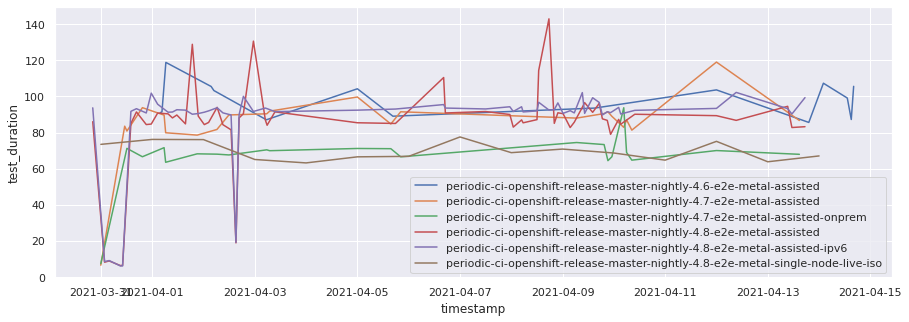

In [16]:
# Here we are plotting the distribution of the test duration metric across different jobs within a given dashboard tab
plot_grids(selected_tab, selected_test, metric_df, selected_kpis[0])

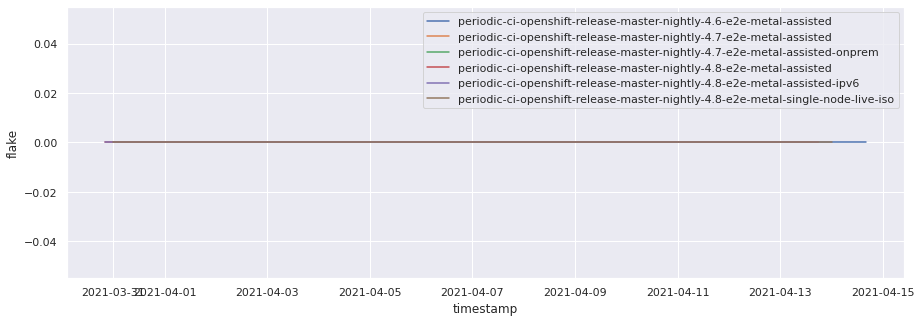

In [17]:
# Here we are plotting the distribution of the Flake severity metric across different jobs within a given dashboard tab
plot_grids(selected_tab, selected_test, metric_df, selected_kpis[1])

## Visualize KPIs for different Tests under a given Job

In this section, we'll compare the various tests that are run in a job, on the basis of the selected KPIs. That is, given a job (e.g. `periodic-ci-openshift-release-master-ci-4.6-e2e-gcp`), we will plot the KPI values corresponding to each test (e.g. `operator conditions cluster-autoscaler`, `operator conditions cloud-credential`, etc.) under that job. This would help us determine if our efforts should be focused on a particular set of components in OpenShift.

In [18]:
# For a given dashboard, identify all the jobs (grids)
selected_tab = '"redhat-openshift-ocp-release-4.1-informing"'

grids = metric_df[metric_df["tab"] == selected_tab]["grid"].unique()
print("Available grids to choose from:", end="\n\n")
for g in grids:
    print(g)

Available grids to choose from:

release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.1-nightly
release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1


In [19]:
# Select the job(grid)
selected_grid = "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1"

In [20]:
df = metric_df.copy()
df = df[(df["tab"] == selected_tab) & (df["grid"] == selected_grid)]
df.head()

,timestamp,tab,grid,test,test_duration,flake
2163889,2021-04-14 00:41:26,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,255.066667,False
2163890,2021-04-13 00:39:54,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,68.900000,False
2163891,2021-04-12 00:38:35,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,61.916667,False
2163892,2021-04-11 00:37:08,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,67.800000,False
2163893,2021-04-10 00:36:09,"""redhat-openshift-ocp-release-4.1-informing""",release-openshift-origin-installer-e2e-aws-upg...,Overall,85.800000,False


<AxesSubplot:xlabel='flake', ylabel='count'>

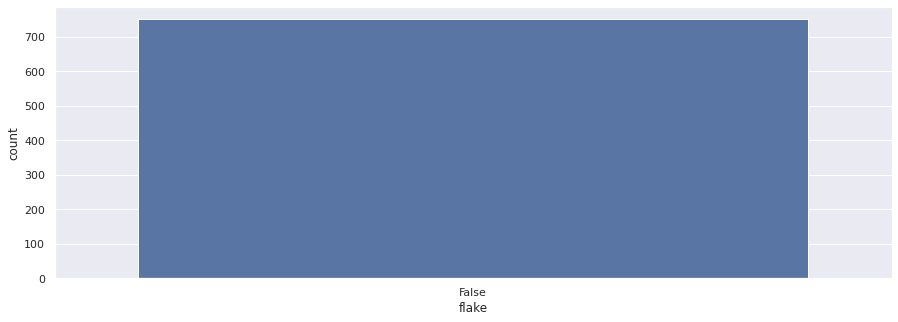

In [21]:
## Count of flakes identified in the tests for a particular grid(job) in a given TestGrid dashboard tab
sns.countplot(x="flake", data=df)

In [22]:
def plot_tests(tab, grid, df, metric_name):
    """
    Takes as an argument the dashboard tab, grid(job), metric data frame and the KPI metric

    Plots the distribution of KPI values over time for the different tests in a job(grid) of a given
    TestGrid dashboard tab
    """
    for test in df[(df["tab"] == tab) & (df["grid"] == grid)]["test"].unique():
        grid_values = pd.DataFrame()
        grid_values = df[
            (df["tab"] == tab) & (df["grid"] == grid) & (df["test"] == test)
        ]
        sns.lineplot(x="timestamp", y=metric_name, data=grid_values, legend="brief")

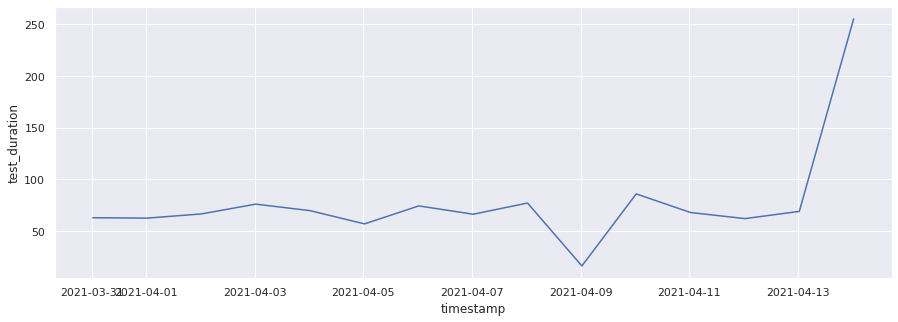

In [17]:
# Here we are plotting the distribution of the test duration metric across different tests within a given dashboard tab
plot_tests(selected_tab, selected_grid, metric_df, selected_kpis[0])

**NOTE** The values for "test_duration" are only available for "Overall" hence the above graph shows only one lineplot.

## Variation of KPI metrics over time

We can plot the KPI metric values over time to identify any change, pattern or trend in the values for different grids(jobs) and different tests

In [25]:
def plot_metrics_tab_grid(tab, grid, df, metric_name, graph_title):
    """
    Takes as an argument the TestGrid dashboard tab, grid(job), metric data frame, the KPI metric name,
    and the title of the graph

    Plots the KPI values over time for the particular grid(job) in a given TestGrid dashboard tab
    Plots change in KPI metrics over time
    """
    df = df[(df["tab"] == tab) & (df["grid"] == grid)]
    print(df.shape)
    sns.set(rc={"figure.figsize": (15, 5)})
    sns.lineplot(x="timestamp", y=metric_name, data=df)
    plt.xlabel("Timestamps")
    plt.ylabel(metric_name)
    plt.title(graph_title)
    plt.show()

(1275, 6)


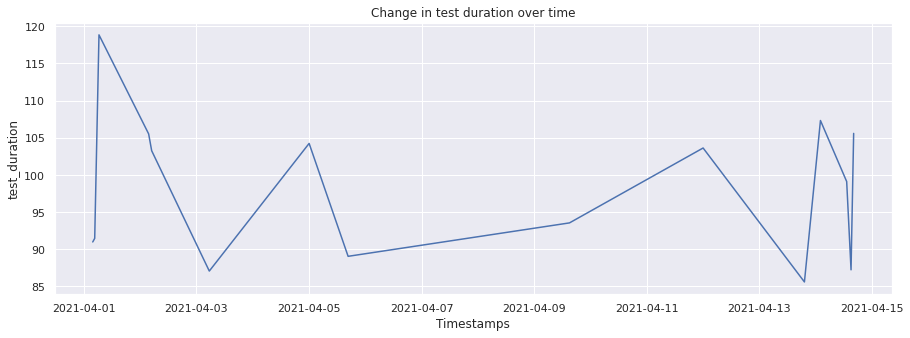

In [26]:
# Select the dashboard tab, grid(job) and the KPI metric you wish to plot the graphs for
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Change in test duration over time",
)

(1748, 6)


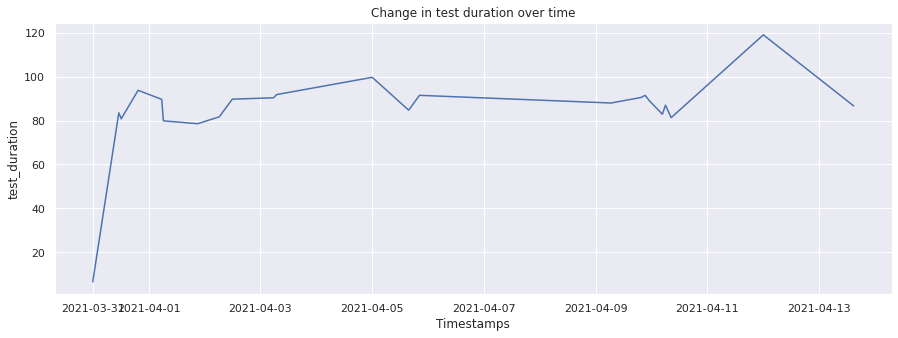

In [27]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Change in test duration over time",
)

(4560, 6)


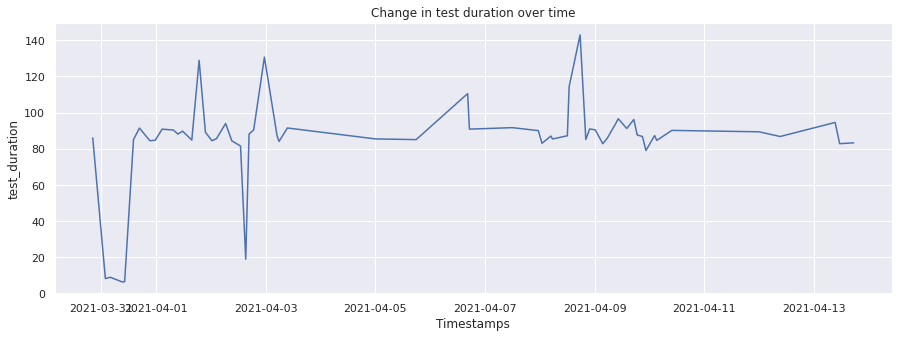

In [28]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric_df,
    selected_kpis[0],
    "Change in test duration over time",
)

(1275, 6)


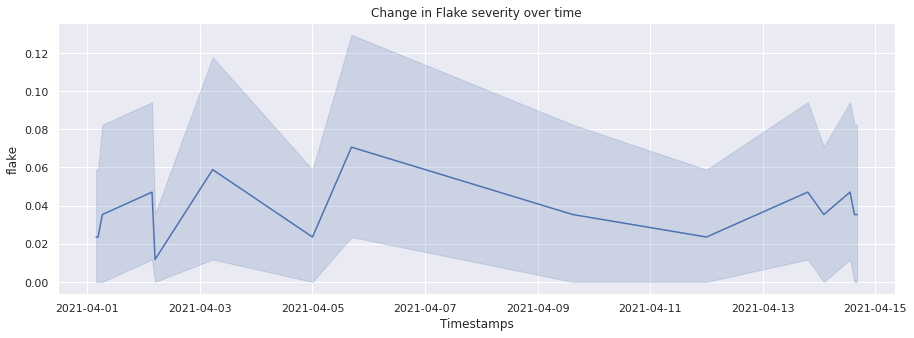

In [29]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.6-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Change in Flake severity over time",
)

(1748, 6)


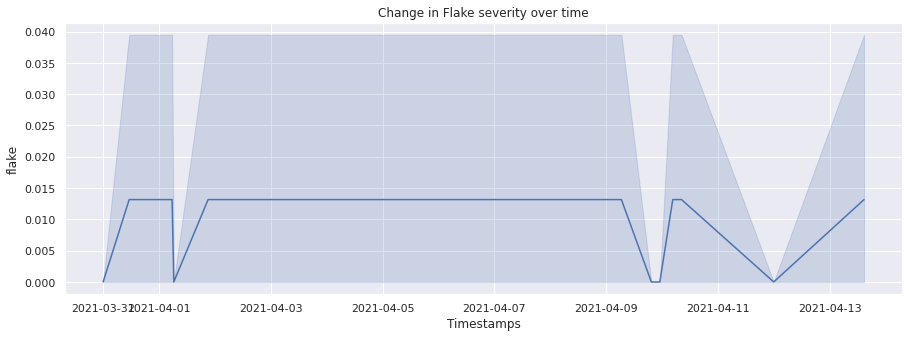

In [30]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.7-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Change in Flake severity over time",
)

(4560, 6)


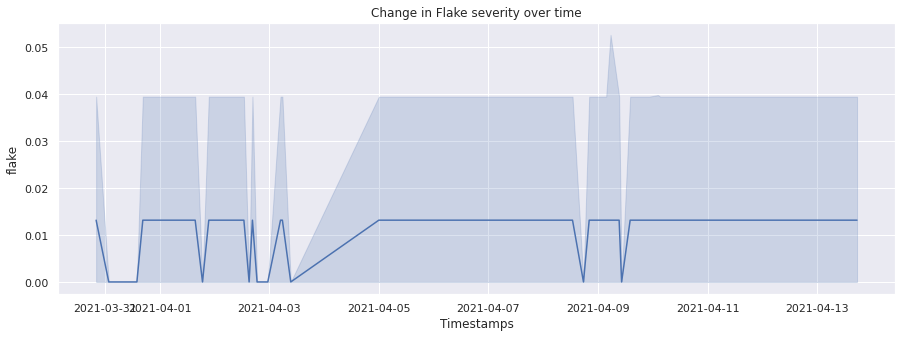

In [31]:
plot_metrics_tab_grid(
    '"redhat-assisted-installer"',
    "periodic-ci-openshift-release-master-nightly-4.8-e2e-metal-assisted",
    metric_df,
    selected_kpis[1],
    "Change in Flake severity over time",
)